# [3주차] 심화과제 - Pre-trained 모델로 효율적인 NLP 모델 학습하기

#### Q1) 어떤 task를 선택하셨나요?
- MNLI task
- MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제이다.
- BERT는 sentence pair classification에 특화되어 있어 MNLI와 같이 두 문장 간의 복잡한 의미 관계를 파악하는데 효과적이다. BERT와 비슷한 성능을 가지면서 사이즈는 작은 DistilBERT를 사용하였다.

#### Q2) 모델은 어떻게 설계하셨나요? 설계한 모델의 입력과 출력 형태가 어떻게 되나요?
- 아래 출력 포함


#### Q3) 실제로 pre-trained 모델을 fine-tuning했을 때 loss curve은 어떻게 그려지나요? 그리고 pre-train 하지 않은 Transformer를 학습했을 때와 어떤 차이가 있나요?




In [1]:
%pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

### 1. 데이터셋 준비

Kaggle 데이터셋을 다운로드 받는다.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


kaggle 데이터셋은 다음과 같이 구성되어 있다.
- premise: 기준이 되는 첫 번째 문장
- hypothesis: 두 번째 문장
- label: 두 문장의 관계
  - entailment: 논리적 연결(0)
  - contradiction: 모순 관계(1)
  - neutral: 무관한 관계(2)

In [3]:
import random
import pandas as pd

def load_data(path, nrows=None):
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data

# 경로 : load_data(path + '/불러올파일명.csv', nrows=1000)
train_data = load_data(path+'/train.csv', nrows=1000)
test_data = load_data(path+'/validation_matched.csv', nrows=1000)

DistilBERT 모델용 tokenizer를 불러온다.

In [4]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


max length를 설정하기 위해 문장의 길이 분포를 확인한다.

train data의 99% 이상이 103 이하이고, test data의 99% 이상이 94 이하이다.

트랜스포머 모델은 8의 배수로 처리할 때 효율적이므로 8 X 103 = 104를 max length로 설정한다.

In [5]:
# 문장 길이 분포 확인
def analyze_length_distribution(data):
    premise_lengths = []
    hypothesis_lengths = []
    total_lengths = []

    # 각 문장을 토큰화하여 길이 계산
    for item in data:
        premise_tokens = tokenizer(item['premise'])['input_ids']
        hypothesis_tokens = tokenizer(item['hypothesis'])['input_ids']

        premise_len = len(premise_tokens)
        hypothesis_len = len(hypothesis_tokens)
        # BERT/DistilBERT는 두 문장을 [CLS] premise [SEP] hypothesis [SEP] 형태로 결합
        # 따라서 총 길이는 premise + hypothesis + 3 ([CLS]와 [SEP] 토큰)
        total_len = premise_len + hypothesis_len + 3

        premise_lengths.append(premise_len)
        hypothesis_lengths.append(hypothesis_len)
        total_lengths.append(total_len)

    print(f"=== 길이 통계 ===")
    print(f"Premise 평균 길이: {sum(premise_lengths)/len(premise_lengths):.1f}")
    print(f"Premise 최대 길이: {max(premise_lengths)}")
    print(f"Hypothesis 평균 길이: {sum(hypothesis_lengths)/len(hypothesis_lengths):.1f}")
    print(f"Hypothesis 최대 길이: {max(hypothesis_lengths)}")
    print(f"전체 시퀀스 평균 길이: {sum(total_lengths)/len(total_lengths):.1f}")
    print(f"전체 시퀀스 최대 길이: {max(total_lengths)}")

    # 90, 95, 99 퍼센타일 계산
    percentiles = [90, 95, 99]
    for p in percentiles:
        threshold = sorted(total_lengths)[int(len(total_lengths) * p/100)]
        print(f"{p}% 문장의 길이: {threshold} 이하")

print("Training Data 분석:")
analyze_length_distribution(train_data)
print("\nTest Data 분석:")
analyze_length_distribution(test_data)

Training Data 분석:
=== 길이 통계 ===
Premise 평균 길이: 26.9
Premise 최대 길이: 189
Hypothesis 평균 길이: 14.1
Hypothesis 최대 길이: 49
전체 시퀀스 평균 길이: 44.1
전체 시퀀스 최대 길이: 215
90% 문장의 길이: 67 이하
95% 문장의 길이: 77 이하
99% 문장의 길이: 103 이하

Test Data 분석:
=== 길이 통계 ===
Premise 평균 길이: 25.4
Premise 최대 길이: 138
Hypothesis 평균 길이: 14.1
Hypothesis 최대 길이: 46
전체 시퀀스 평균 길이: 42.5
전체 시퀀스 최대 길이: 165
90% 문장의 길이: 65 이하
95% 문장의 길이: 74 이하
99% 문장의 길이: 94 이하


In [6]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader


def collate_fn(batch):
    premises, hypotheses, labels = [], [], []

    # 배치 내 각 샘플에서 premise, hypothesis, label 추출
    for row in batch:
        premises.append(row['premise'])
        hypotheses.append(row['hypothesis'])
        labels.append(row['label'])

    # tokenizer로 두 문장을 함께 토큰화
    encoded = tokenizer(
        premises,
        hypotheses,
        padding=True,
        truncation=True,
        max_length=104,
        # PyTorch 텐서로 변환하여 반환한다.
        return_tensors='pt'
    )

    # label을 텐서로 변환한다
    labels = torch.LongTensor(labels)

    # 모델 입력에 필요한 모든 정보 반환
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'labels': labels
    }

batch_size = 16

# DataLoader 설정
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# 데이터 형태 확인
for batch in train_loader:
    print("배치 크기:", batch['input_ids'].shape)
    print("어텐션 마스크 크기:", batch['attention_mask'].shape)
    print("라벨 크기:", batch['labels'].shape)
    print("\n첫 번째 배치 예시:")
    print("입력 ID:", batch['input_ids'][0])
    print("라벨:", batch['labels'][0])
    break

배치 크기: torch.Size([16, 73])
어텐션 마스크 크기: torch.Size([16, 73])
라벨 크기: torch.Size([16])

첫 번째 배치 예시:
입력 ID: tensor([  101,  2023,  2003,  2035,  5760,  2152,  1011, 27604,  1998, 29348,
         1010, 24987,  2007,  4510, 20099, 17440,  1055, 25083, 18477,  2213,
         1010,  2021,  2036, 18834, 12228,  2524, 10861,  5134,  1998, 19657,
        10960,  1012,   102,  2023,  2003, 27885,  3630, 25171,  1998,  1055,
        25083,  3762,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])
라벨: tensor(0)


### 2. 모델 정의

MNLI task를 위해 시퀀스 분류용 모델 DistilBertForSequenceClassification을 불러온다.

DistilBertForSequenceClassification은 기본 DistillBERT에 분류를 위한 선형 레이어가 추가되어 있다.

In [7]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3, # entailment, contradiction, neutral
    dropout=0.3
)

# GPU를 사용하기 위한 옵션
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델의 입력과 출력, 예측 결과 형태를 확인한다.

In [8]:
# 예시 데이터
premise = "Conceptually cream skimming has two basic dimensions - product and geography."
hypothesis = "Product and geography are what make cream skimming work."

# 입력 형태
encoded = tokenizer(
    premise,
    hypothesis,
    padding=True,
    truncation=True,
    max_length=104,
    return_tensors='pt'
)
encoded = {k: v.to(device) for k, v in encoded.items()}

print("=== 입력 형태 ===")
print("input_ids 형태:", encoded['input_ids'].shape)
print("attention_mask 형태:", encoded['attention_mask'].shape)

# 모델 출력
outputs = model(**encoded)
print("\n=== 출력 형태 ===")
print("로짓 형태:", outputs.logits.shape)  # [batch_size, 3] - 3개 클래스에 대한 점수

# 예측 클래스
predicted_class = torch.argmax(outputs.logits, dim=1)
print("\n=== 예측 결과 ===")
print("예측 클래스:", predicted_class.item())  # 0: entailment, 1: contradiction, 2: neutral

# 레이블과 예측값 매핑
label_map = {0: 'entailment', 1: 'contradiction', 2: 'neutral'}
print("예측 결과:", label_map[predicted_class.item()])

=== 입력 형태 ===
input_ids 형태: torch.Size([1, 28])
attention_mask 형태: torch.Size([1, 28])

=== 출력 형태 ===
로짓 형태: torch.Size([1, 3])

=== 예측 결과 ===
예측 클래스: 2
예측 결과: neutral


### 3. Fine tuning

fine tuning 전/후를 비교하기 위해 정확도를 계산하고 모델의 성능을 평가하는 함수를 추가한다.

In [9]:
# 정확도 계산 함수
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return correct / total

# 모델 성능 평가 함수
def evaluate(model, train_loader, test_loader, title_prefix=""):
    # 정확도 계산
    train_acc = compute_accuracy(model, train_loader)
    test_acc = compute_accuracy(model, test_loader)

    print(f"\n=== {title_prefix} 모델 성능 ===")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return train_acc, test_acc

overfitting을 방지하기 위해 early stopping을 정의한다.

In [10]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, verbose=True):
        """
        patience: 성능 향상이 없어도 기다리는 에폭 수
        min_delta: 성능 향상으로 간주할 최소 변화량
        verbose: 상세 출력 여부
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.best_acc = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, val_acc, model):
        if self.best_loss is None:  # 첫 에폭
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:  # 성능 향상이 없는 경우
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Early stopping triggered! Best accuracy: {self.best_acc:.4f}')
        else:  # 성능이 향상된 경우
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model = model.state_dict()
            self.counter = 0

학습 함수를 정의한다.

overfitting을 방지하기 위해 early stop을 추가하고 epochs를 넉넉하게 설정하였다.

In [11]:
import torch
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

# 학습 함수
def train_model(model, train_loader, test_loader):
    model = model.to(device)

    # transformer 미세조정에 적합한 learning rate
    lr = 2e-5
    n_epochs = 50

    # AdamW 옵티마이저 사용 (트랜스포머 모델에 더 적합)
    optimizer = AdamW(model.parameters(), lr=lr)

    # Early Stopping 초기화
    early_stopping = EarlyStopping(
        patience=3,  # 3번 연속으로 성능 향상이 없으면 중단
        min_delta=0.001,  # 최소 0.1%p 향상을 기대
        verbose=True
    )

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}')

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 에폭마다 정확도 계산
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"\nEpoch {epoch + 1}/{n_epochs}")
        print(f"Total Loss: {total_loss:.4f}")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}\n")

        # Early Stopping 체크
        early_stopping(avg_loss, test_acc, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")
            # 최고 성능 모델로 복원
            model.load_state_dict(early_stopping.best_model)
            break

    return train_losses, train_accs, test_accs

fine tuning 전/후 성능을 측정한다.


=== Fine-tuning 전 모델 성능 ===
Train Accuracy: 0.2870
Test Accuracy: 0.3200

=== Fine-tuning 시작 ===


Epoch 1/50: 100%|██████████| 63/63 [00:02<00:00, 25.65it/s, loss=1.16]



Epoch 1/50
Total Loss: 69.1691
Average Loss: 1.0979
Train Accuracy: 0.3760
Test Accuracy: 0.3460



Epoch 2/50: 100%|██████████| 63/63 [00:02<00:00, 25.88it/s, loss=1.08]



Epoch 2/50
Total Loss: 68.7101
Average Loss: 1.0906
Train Accuracy: 0.3850
Test Accuracy: 0.3450



Epoch 3/50: 100%|██████████| 63/63 [00:02<00:00, 25.75it/s, loss=1.09]



Epoch 3/50
Total Loss: 68.5848
Average Loss: 1.0886
Train Accuracy: 0.4040
Test Accuracy: 0.3610



Epoch 4/50: 100%|██████████| 63/63 [00:02<00:00, 25.47it/s, loss=1.18]



Epoch 4/50
Total Loss: 68.5094
Average Loss: 1.0875
Train Accuracy: 0.4120
Test Accuracy: 0.3530



Epoch 5/50: 100%|██████████| 63/63 [00:02<00:00, 25.92it/s, loss=1.11]



Epoch 5/50
Total Loss: 68.3631
Average Loss: 1.0851
Train Accuracy: 0.4150
Test Accuracy: 0.3570



Epoch 6/50: 100%|██████████| 63/63 [00:02<00:00, 26.25it/s, loss=1.14]



Epoch 6/50
Total Loss: 68.0619
Average Loss: 1.0803
Train Accuracy: 0.4250
Test Accuracy: 0.3560



Epoch 7/50: 100%|██████████| 63/63 [00:02<00:00, 25.83it/s, loss=1.05]



Epoch 7/50
Total Loss: 67.8831
Average Loss: 1.0775
Train Accuracy: 0.4260
Test Accuracy: 0.3540



Epoch 8/50: 100%|██████████| 63/63 [00:02<00:00, 27.04it/s, loss=1.08]



Epoch 8/50
Total Loss: 67.6856
Average Loss: 1.0744
Train Accuracy: 0.4240
Test Accuracy: 0.3570



Epoch 9/50: 100%|██████████| 63/63 [00:02<00:00, 26.24it/s, loss=1.05]



Epoch 9/50
Total Loss: 67.7228
Average Loss: 1.0750
Train Accuracy: 0.4310
Test Accuracy: 0.3500

EarlyStopping counter: 1 out of 3


Epoch 10/50: 100%|██████████| 63/63 [00:02<00:00, 26.58it/s, loss=1.02]



Epoch 10/50
Total Loss: 67.5618
Average Loss: 1.0724
Train Accuracy: 0.4360
Test Accuracy: 0.3540



Epoch 11/50: 100%|██████████| 63/63 [00:02<00:00, 26.31it/s, loss=1.11]



Epoch 11/50
Total Loss: 67.4349
Average Loss: 1.0704
Train Accuracy: 0.4360
Test Accuracy: 0.3520



Epoch 12/50: 100%|██████████| 63/63 [00:02<00:00, 27.11it/s, loss=0.954]



Epoch 12/50
Total Loss: 67.0415
Average Loss: 1.0642
Train Accuracy: 0.4390
Test Accuracy: 0.3530



Epoch 13/50: 100%|██████████| 63/63 [00:02<00:00, 26.93it/s, loss=0.993]



Epoch 13/50
Total Loss: 67.1071
Average Loss: 1.0652
Train Accuracy: 0.4440
Test Accuracy: 0.3600

EarlyStopping counter: 1 out of 3


Epoch 14/50: 100%|██████████| 63/63 [00:02<00:00, 23.93it/s, loss=1.2]



Epoch 14/50
Total Loss: 67.2886
Average Loss: 1.0681
Train Accuracy: 0.4410
Test Accuracy: 0.3560

EarlyStopping counter: 2 out of 3


Epoch 15/50: 100%|██████████| 63/63 [00:02<00:00, 26.68it/s, loss=1.01]



Epoch 15/50
Total Loss: 66.9321
Average Loss: 1.0624
Train Accuracy: 0.4490
Test Accuracy: 0.3680



Epoch 16/50: 100%|██████████| 63/63 [00:02<00:00, 25.25it/s, loss=1.08]



Epoch 16/50
Total Loss: 66.7794
Average Loss: 1.0600
Train Accuracy: 0.4430
Test Accuracy: 0.3600



Epoch 17/50: 100%|██████████| 63/63 [00:02<00:00, 27.09it/s, loss=1.04]



Epoch 17/50
Total Loss: 66.5571
Average Loss: 1.0565
Train Accuracy: 0.4550
Test Accuracy: 0.3680



Epoch 18/50: 100%|██████████| 63/63 [00:02<00:00, 25.26it/s, loss=1.04]



Epoch 18/50
Total Loss: 66.4247
Average Loss: 1.0544
Train Accuracy: 0.4560
Test Accuracy: 0.3760



Epoch 19/50: 100%|██████████| 63/63 [00:02<00:00, 25.82it/s, loss=1.03]



Epoch 19/50
Total Loss: 66.3089
Average Loss: 1.0525
Train Accuracy: 0.4590
Test Accuracy: 0.3690



Epoch 20/50: 100%|██████████| 63/63 [00:02<00:00, 26.60it/s, loss=1.14]



Epoch 20/50
Total Loss: 66.1737
Average Loss: 1.0504
Train Accuracy: 0.4500
Test Accuracy: 0.3680



Epoch 21/50: 100%|██████████| 63/63 [00:02<00:00, 27.00it/s, loss=1.16]



Epoch 21/50
Total Loss: 66.1947
Average Loss: 1.0507
Train Accuracy: 0.4640
Test Accuracy: 0.3660

EarlyStopping counter: 1 out of 3


Epoch 22/50: 100%|██████████| 63/63 [00:02<00:00, 27.14it/s, loss=0.983]



Epoch 22/50
Total Loss: 65.8777
Average Loss: 1.0457
Train Accuracy: 0.4720
Test Accuracy: 0.3720



Epoch 23/50: 100%|██████████| 63/63 [00:02<00:00, 26.17it/s, loss=1.09]



Epoch 23/50
Total Loss: 65.9686
Average Loss: 1.0471
Train Accuracy: 0.4680
Test Accuracy: 0.3710

EarlyStopping counter: 1 out of 3


Epoch 24/50: 100%|██████████| 63/63 [00:02<00:00, 26.79it/s, loss=1.09]



Epoch 24/50
Total Loss: 65.6883
Average Loss: 1.0427
Train Accuracy: 0.4740
Test Accuracy: 0.3730



Epoch 25/50: 100%|██████████| 63/63 [00:02<00:00, 25.20it/s, loss=1.1]



Epoch 25/50
Total Loss: 65.7805
Average Loss: 1.0441
Train Accuracy: 0.4890
Test Accuracy: 0.3720

EarlyStopping counter: 1 out of 3


Epoch 26/50: 100%|██████████| 63/63 [00:02<00:00, 26.06it/s, loss=0.994]



Epoch 26/50
Total Loss: 65.5132
Average Loss: 1.0399
Train Accuracy: 0.4770
Test Accuracy: 0.3720



Epoch 27/50: 100%|██████████| 63/63 [00:02<00:00, 25.38it/s, loss=1.1]



Epoch 27/50
Total Loss: 65.0313
Average Loss: 1.0322
Train Accuracy: 0.4930
Test Accuracy: 0.3750



Epoch 28/50: 100%|██████████| 63/63 [00:02<00:00, 25.88it/s, loss=0.98]



Epoch 28/50
Total Loss: 65.1564
Average Loss: 1.0342
Train Accuracy: 0.4920
Test Accuracy: 0.3730

EarlyStopping counter: 1 out of 3


Epoch 29/50: 100%|██████████| 63/63 [00:02<00:00, 25.96it/s, loss=0.997]



Epoch 29/50
Total Loss: 64.8927
Average Loss: 1.0300
Train Accuracy: 0.4970
Test Accuracy: 0.3790



Epoch 30/50: 100%|██████████| 63/63 [00:02<00:00, 26.95it/s, loss=0.979]



Epoch 30/50
Total Loss: 65.1545
Average Loss: 1.0342
Train Accuracy: 0.4990
Test Accuracy: 0.3780

EarlyStopping counter: 1 out of 3


Epoch 31/50: 100%|██████████| 63/63 [00:02<00:00, 26.13it/s, loss=1.01]



Epoch 31/50
Total Loss: 64.7472
Average Loss: 1.0277
Train Accuracy: 0.4990
Test Accuracy: 0.3800



Epoch 32/50: 100%|██████████| 63/63 [00:02<00:00, 25.89it/s, loss=1.11]



Epoch 32/50
Total Loss: 64.9589
Average Loss: 1.0311
Train Accuracy: 0.4980
Test Accuracy: 0.3790

EarlyStopping counter: 1 out of 3


Epoch 33/50: 100%|██████████| 63/63 [00:02<00:00, 26.20it/s, loss=1.14]



Epoch 33/50
Total Loss: 64.7132
Average Loss: 1.0272
Train Accuracy: 0.4990
Test Accuracy: 0.3870

EarlyStopping counter: 2 out of 3


Epoch 34/50: 100%|██████████| 63/63 [00:02<00:00, 25.39it/s, loss=0.943]



Epoch 34/50
Total Loss: 64.1755
Average Loss: 1.0187
Train Accuracy: 0.5100
Test Accuracy: 0.3850



Epoch 35/50: 100%|██████████| 63/63 [00:02<00:00, 26.61it/s, loss=1]



Epoch 35/50
Total Loss: 64.3338
Average Loss: 1.0212
Train Accuracy: 0.5060
Test Accuracy: 0.3870

EarlyStopping counter: 1 out of 3


Epoch 36/50: 100%|██████████| 63/63 [00:02<00:00, 26.50it/s, loss=1.05]



Epoch 36/50
Total Loss: 64.1118
Average Loss: 1.0176
Train Accuracy: 0.5110
Test Accuracy: 0.3870



Epoch 37/50: 100%|██████████| 63/63 [00:02<00:00, 26.59it/s, loss=0.954]



Epoch 37/50
Total Loss: 64.0844
Average Loss: 1.0172
Train Accuracy: 0.5090
Test Accuracy: 0.3870

EarlyStopping counter: 1 out of 3


Epoch 38/50: 100%|██████████| 63/63 [00:02<00:00, 26.57it/s, loss=1.07]



Epoch 38/50
Total Loss: 64.3052
Average Loss: 1.0207
Train Accuracy: 0.5100
Test Accuracy: 0.3820

EarlyStopping counter: 2 out of 3


Epoch 39/50: 100%|██████████| 63/63 [00:02<00:00, 25.79it/s, loss=1.1]



Epoch 39/50
Total Loss: 64.0381
Average Loss: 1.0165
Train Accuracy: 0.5130
Test Accuracy: 0.3890



Epoch 40/50: 100%|██████████| 63/63 [00:02<00:00, 26.87it/s, loss=1.03]



Epoch 40/50
Total Loss: 63.8773
Average Loss: 1.0139
Train Accuracy: 0.5200
Test Accuracy: 0.3850



Epoch 41/50: 100%|██████████| 63/63 [00:02<00:00, 26.09it/s, loss=1]



Epoch 41/50
Total Loss: 64.0620
Average Loss: 1.0169
Train Accuracy: 0.5110
Test Accuracy: 0.3880

EarlyStopping counter: 1 out of 3


Epoch 42/50: 100%|██████████| 63/63 [00:02<00:00, 26.71it/s, loss=1.11]



Epoch 42/50
Total Loss: 63.7476
Average Loss: 1.0119
Train Accuracy: 0.5250
Test Accuracy: 0.3870



Epoch 43/50: 100%|██████████| 63/63 [00:02<00:00, 25.82it/s, loss=0.95]



Epoch 43/50
Total Loss: 63.3190
Average Loss: 1.0051
Train Accuracy: 0.5210
Test Accuracy: 0.3840



Epoch 44/50: 100%|██████████| 63/63 [00:02<00:00, 26.69it/s, loss=1.02]



Epoch 44/50
Total Loss: 63.0893
Average Loss: 1.0014
Train Accuracy: 0.5370
Test Accuracy: 0.3790



Epoch 45/50: 100%|██████████| 63/63 [00:02<00:00, 26.24it/s, loss=1]



Epoch 45/50
Total Loss: 63.1803
Average Loss: 1.0029
Train Accuracy: 0.5430
Test Accuracy: 0.3820

EarlyStopping counter: 1 out of 3


Epoch 46/50: 100%|██████████| 63/63 [00:02<00:00, 26.29it/s, loss=0.944]



Epoch 46/50
Total Loss: 63.3050
Average Loss: 1.0048
Train Accuracy: 0.5380
Test Accuracy: 0.3910

EarlyStopping counter: 2 out of 3


Epoch 47/50: 100%|██████████| 63/63 [00:02<00:00, 26.71it/s, loss=0.917]



Epoch 47/50
Total Loss: 63.3495
Average Loss: 1.0055
Train Accuracy: 0.5490
Test Accuracy: 0.3870

EarlyStopping counter: 3 out of 3
Early stopping triggered! Best accuracy: 0.3790

Early stopping triggered at epoch 47

=== Fine-tuning 후 모델 성능 ===
Train Accuracy: 0.5490
Test Accuracy: 0.3870


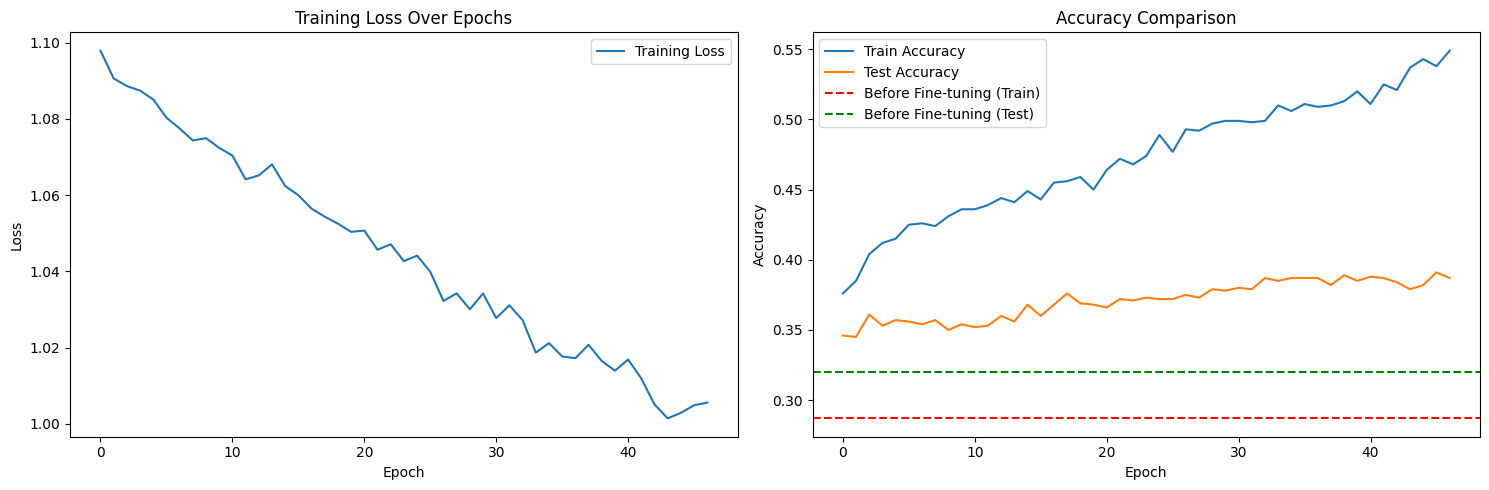


=== 성능 향상 분석 ===
Train Accuracy 향상: 26.20%
Test Accuracy 향상: 6.70%


In [12]:
# 1. Fine-tuning 전 성능 평가
before_train_acc, before_test_acc = evaluate(
    model, train_loader, test_loader, "Fine-tuning 전"
)

# 2. Fine-tuning 수행
print("\n=== Fine-tuning 시작 ===")
for param in model.distilbert.parameters():
    param.requires_grad = False

train_losses, train_accs, test_accs = train_model(
    model, train_loader, test_loader
)

# 3. Fine-tuning 후 성능 평가
after_train_acc, after_test_acc = evaluate(
    model, train_loader, test_loader, "Fine-tuning 후"
)

# 4. 결과 시각화
plt.figure(figsize=(15, 5))

# 학습 중 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.axhline(y=before_train_acc, color='r', linestyle='--', label='Before Fine-tuning (Train)')
plt.axhline(y=before_test_acc, color='g', linestyle='--', label='Before Fine-tuning (Test)')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 향상 출력
print("\n=== 성능 향상 분석 ===")
print(f"Train Accuracy 향상: {(after_train_acc - before_train_acc)*100:.2f}%")
print(f"Test Accuracy 향상: {(after_test_acc - before_test_acc)*100:.2f}%")